# 영화 필터링

- 이상한 영화들이 존재하여 제거해야함.

In [ ]:
import pandas as pd

movie_metadata = pd.read_excel("cinemate_data_0511.xlsx")
final_metadata = pd.read_excel("final_metadata_with_overview_embeddings_ver5_0511.xlsx")

In [ ]:
final_metadata

In [ ]:
# movie_metadata 내에서 title이 영어이거나 한국어가 아닌 것들
movie_metadata[~(movie_metadata['title'].str.contains('[a-zA-Z]') | movie_metadata['title'].str.contains('[가-힣]'))]

In [ ]:
# movie_metadata 내에서 title이 영어이거나 한국어인 것들의 인덱스로 final_metadata에서 해당 데이터만 추출
final_metadata = final_metadata.iloc[movie_metadata[(movie_metadata['title'].str.contains('[a-zA-Z]') | movie_metadata['title'].str.contains('[가-힣]'))].index]

In [ ]:
final_metadata.to_excel("final_metadata_with_overview_embeddings_only_eng_kor_0528.xlsx", index=False)

In [8]:
import pandas as pd

final_metadata = pd.read_excel("final_metadata_with_overview_embeddings_only_eng_kor_0528.xlsx")

## 변경한 데이터의 장르 정보 확인

tconst             tt6147768
primaryTitle           Split
originalTitle     Suepeullit
startYear               2016
runtimeMinutes           123
                     ...    
embedding_379      -0.002548
embedding_380       0.005766
embedding_381       0.000557
embedding_382       0.029496
embedding_383       0.008394
Name: 4118, Length: 396, dtype: object
['Action', 'Drama', 'Sport']


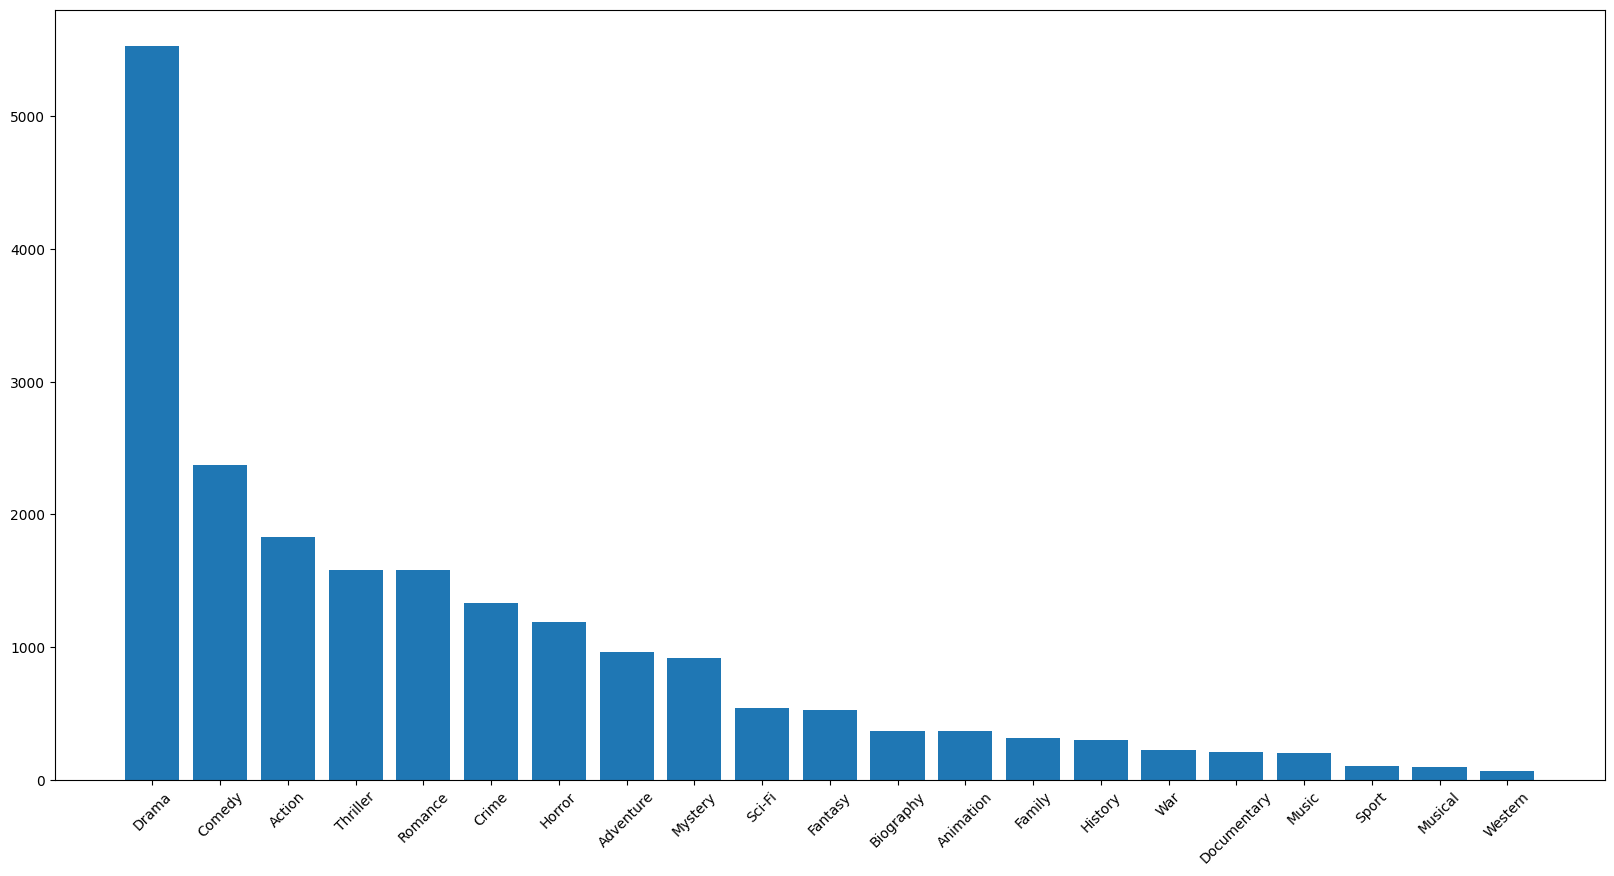

In [13]:
# 각 영화의 인덱스를 키로, 해당 영화의 장르를 값으로 가지는 딕셔너리 생성
movie_genres = {}
for index, row in final_metadata.iterrows():
    if index == 4118:
        print(row)
        print(row.iloc[5].split(','))
    genres = row.iloc[5].split(',')  # ','로 장르 분리
    movie_genres[index] = set(genres)  # 장르 집합 생성하여 딕셔너리에 저장
# movie_genres
# 각 장르별 영화 개수 plot
import matplotlib.pyplot as plt

genre_count = {}
for genres in movie_genres.values():
    for genre in genres:
        if genre in genre_count:
            genre_count[genre] += 1
        else:
            genre_count[genre] = 1
genre_count = dict(sorted(genre_count.items(), key=lambda x: x[1], reverse=True))
plt.figure(figsize=(20, 10))
plt.bar(genre_count.keys(), genre_count.values())
plt.xticks(rotation=45)
plt.show()

In [ ]:
genre_count

In [ ]:
# final_metadata 초기화
final_metadata.reset_index(drop=True, inplace=True)

In [ ]:
final_metadata

# 장르 one-hot encoding

In [ ]:
genres_one_hot_encoded = final_metadata.genres.str.get_dummies(sep=',')
genres_one_hot_encoded

# 감독, 배우 one-hot encoding

In [ ]:
unique_directors_combinations = final_metadata['directors'].unique()
# unique_directors_combinations.__len__()
unique_directors = set()

for combination in unique_directors_combinations:
    directors = combination.split(',')
    unique_directors.update(directors)

print(sorted(unique_directors))
directors_one_hot_encoded = final_metadata.directors.str.get_dummies(sep=',')
# final_metadata[directors_one_hot_encoded.sum(axis=1) > 1]
directors_one_hot_encoded

In [ ]:
unique_actors_combinations = final_metadata['actors'].unique()
unique_actors = set()

for combination in unique_actors_combinations:
    actors = combination.split(',')
    unique_actors.update(actors)

print(sorted(unique_actors))
actors_one_hot_encoded = final_metadata.actors.str.get_dummies(sep=',')
# final_metadata[actors_one_hot_encoded.sum(axis=1) > 1]
actors_one_hot_encoded

# PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
directors_pca = pca.fit_transform(directors_one_hot_encoded)
directors_pca_df = pd.DataFrame(directors_pca, columns=[f'director_pca_{i+1}' for i in range(10)])

actors_pca = pca.fit_transform(actors_one_hot_encoded)
actors_pca_df = pd.DataFrame(actors_pca, columns=[f'actor_pca_{i+1}' for i in range(10)])

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
genres_pca = pca.fit_transform(genres_one_hot_encoded)
genres_pca_df = pd.DataFrame(genres_pca, columns=[f'genre_pca_{i+1}' for i in range(10)])
genres_pca_df

In [ ]:
final_features = pd.concat([directors_pca_df, actors_pca_df, genres_pca_df * 2, final_metadata.iloc[:, -384:]], axis=1)
final_features

In [ ]:
import numpy as np

np.save('final_features_0528.npy', final_features.to_numpy())

In [ ]:
movie_metadata = movie_metadata[(movie_metadata['title'].str.contains('[a-zA-Z]') | movie_metadata['title'].str.contains('[가-힣]'))]

In [ ]:
movie_metadata.reset_index(drop=True, inplace=True)
movie_metadata

In [ ]:
movie_metadata.to_excel("cinemate_data_only_eng_kor_0528.xlsx", index=False)

## nan 값 처리

In [ ]:
movie_metadata.loc[movie_metadata.backdrop_path.isnull(), 'backdrop_path'] = None
movie_metadata.loc[movie_metadata.poster_path.isnull(), 'poster_path'] = None
movie_metadata.loc[movie_metadata.overview.isnull(), 'overview'] = ""

# SQL 문 생성

In [ ]:
genre_mapping = {
    "Action": 1,
    "Adventure": 2,
    "Animation": 3,
    "Biography": 4,
    "Comedy": 5,
    "Crime": 6,
    "Documentary": 7,
    "Drama": 8,
    "Family": 9,
    "Fantasy": 10,
    "History": 11,
    "Horror": 12,
    "Music": 13,
    "Musical": 14,
    "Mystery": 15,
    "Romance": 16,
    "Sci-Fi": 17,
    "Sport": 18,
    "Thriller": 19,
    "War": 20,
    "Western": 21
}

In [ ]:
# 영화 데이터 삽입
movie_insert_sql = """
INSERT INTO movie (id, movie_id, rating, backdrop_path, original_title, movie_title, release_date, poster_path, overview)
VALUES ({}, {}, {}, '{}', '{}', '{}', '{}', '{}', '{}');
"""

movies_sql_statements = []

for index, row in movie_metadata.iterrows():
    print(row['backdrop_path'])
    backdrop_path = "https://image.tmdb.org/t/p/original" + row['backdrop_path'] if row['backdrop_path'] else None
    poster_path = "https://image.tmdb.org/t/p/original" + row['poster_path'] if row['poster_path'] else None
    movie_data = (
        index + 1,
        row['movie_id'],
        row['rating'],
        backdrop_path,
        row['original_title'].replace("'", "''"),
        row['title'].replace("'", "''"),
        row['release_date'],
        poster_path,
        row['overview'].replace("'", "''")
    )
    movie_sql = movie_insert_sql.format(*movie_data)
    movies_sql_statements.append(movie_sql)

# # 장르 데이터 삽입
# genre_insert_sql = """
# INSERT INTO genre (genre_name)
# VALUES ('{}');
# """

# genres_sql_statements = []

# # 장르 데이터를 중복 없이 추출
# genres_set = set()
# for index, row in cinemate_data.iterrows():
#     genres = row['genres'].split(',')
#     for genre in genres:
#         genres_set.add(genre.strip())

# # 중복 없는 장르 데이터를 DB에 삽입
# for genre in genres_set:
#     genre_sql = genre_insert_sql.format(genre.strip())
#     genres_sql_statements.append(genre_sql)

# 영화와 장르의 관계 데이터 삽입
movie_genre_mapping_insert_sql = """
INSERT INTO genre_movie (genre_id, movie_id)
VALUES ({}, {});
"""

movie_genre_sql_statements = []

for index, row in final_metadata.iterrows():
    genres = row['genres'].split(',')
    for genre in genres:
        genre_id = genre_mapping[genre]
        movie_genre_sql = movie_genre_mapping_insert_sql.format(genre_id, index + 1)
        movie_genre_sql_statements.append(movie_genre_sql)

# SQL 쿼리를 파일에 쓰기
with open('data_ver2.sql', 'w') as f:
    for sql_statement in movies_sql_statements + movie_genre_sql_statements:
        f.write(sql_statement + '\n')

# 장르별 index

In [11]:
movie_genres.get(4118)

{'Action', 'Drama', 'Sport'}

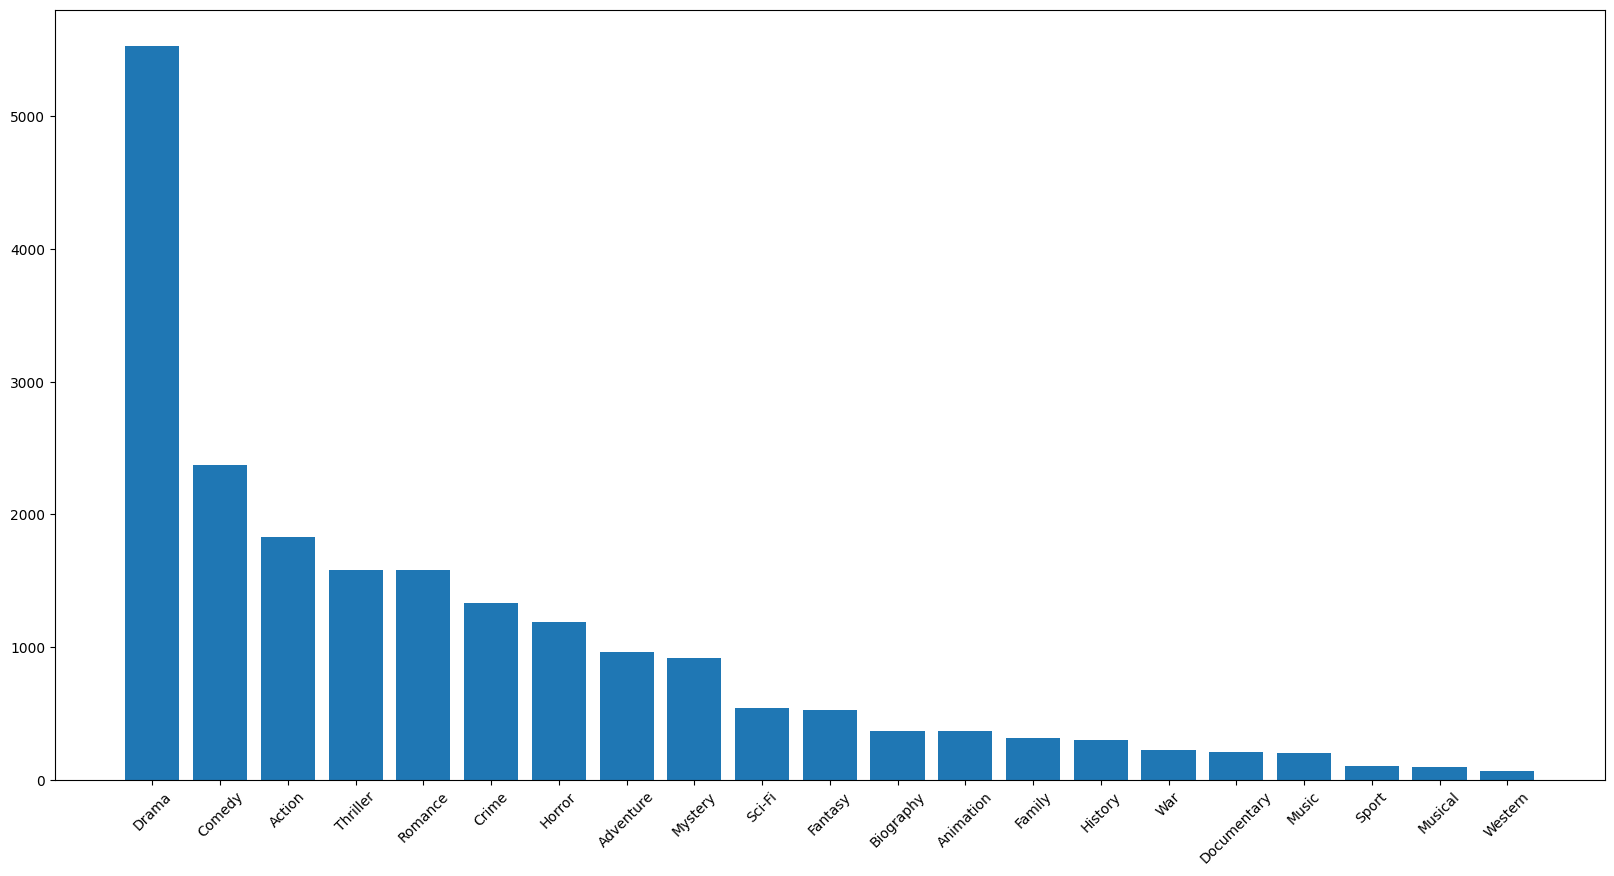

In [61]:
# 각 장르별 영화 개수 plot
import matplotlib.pyplot as plt

genre_count = {}
for genres in movie_genres.values():
    for genre in genres:
        if genre in genre_count:
            genre_count[genre] += 1
        else:
            genre_count[genre] = 1
genre_count = dict(sorted(genre_count.items(), key=lambda x: x[1], reverse=True))
plt.figure(figsize=(20, 10))
plt.bar(genre_count.keys(), genre_count.values())
plt.xticks(rotation=45)
plt.show()

In [62]:
genre_count

{'Drama': 5529,
 'Comedy': 2375,
 'Action': 1828,
 'Thriller': 1583,
 'Romance': 1577,
 'Crime': 1332,
 'Horror': 1189,
 'Adventure': 962,
 'Mystery': 919,
 'Sci-Fi': 541,
 'Fantasy': 526,
 'Biography': 364,
 'Animation': 363,
 'Family': 315,
 'History': 301,
 'War': 221,
 'Documentary': 207,
 'Music': 199,
 'Sport': 105,
 'Musical': 92,
 'Western': 66}

In [64]:
import numpy as np

for genre in genre_count.keys():
    print(f"Genre: {genre}")
    print(final_metadata[final_metadata['genres'].str.contains(genre)].index)
    # store indexs of final_metadata by genre in npy file
    np.save(f"./server/genre_index/{genre}_indexs.npy", final_metadata[final_metadata['genres'].str.contains(genre)].index)

Genre: Drama
Index([   0,    1,    6,    8,    9,   11,   12,   14,   15,   17,
       ...
       9292, 9293, 9294, 9295, 9297, 9298, 9300, 9301, 9302, 9303],
      dtype='int64', length=5529)
Genre: Comedy
Index([   6,   10,   14,   15,   18,   25,   28,   34,   36,   40,
       ...
       9264, 9268, 9274, 9275, 9278, 9285, 9288, 9291, 9296, 9299],
      dtype='int64', length=2375)
Genre: Action
Index([   4,    6,    7,    9,   17,   23,   32,   34,   36,   55,
       ...
       9155, 9182, 9187, 9188, 9216, 9218, 9226, 9248, 9296, 9297],
      dtype='int64', length=1828)
Genre: Thriller
Index([   2,    3,    4,    5,   16,   31,   48,   50,   53,   61,
       ...
       9149, 9152, 9156, 9159, 9167, 9186, 9189, 9233, 9238, 9284],
      dtype='int64', length=1583)
Genre: Romance
Index([   8,   11,   12,   18,   25,   40,   43,   44,   46,   48,
       ...
       9279, 9280, 9285, 9287, 9288, 9290, 9293, 9297, 9301, 9303],
      dtype='int64', length=1577)
Genre: Crime
Index([   4,   

# Movies for Survey

In [65]:
import pandas as pd

movie_metadata = pd.read_excel("cinemate_data_only_eng_kor_0528.xlsx")
final_metadata = pd.read_excel("final_metadata_with_overview_embeddings_only_eng_kor_0528.xlsx")

In [3]:
import numpy as np
import glob

# 모든 npy 파일 읽어오기
npy_files = glob.glob("./server/genre_index/*.npy")
npy_files

['./server/genre_index/History_indexs.npy',
 './server/genre_index/Thriller_indexs.npy',
 './server/genre_index/Adventure_indexs.npy',
 './server/genre_index/Drama_indexs.npy',
 './server/genre_index/Sci-Fi_indexs.npy',
 './server/genre_index/Sport_indexs.npy',
 './server/genre_index/Crime_indexs.npy',
 './server/genre_index/Romance_indexs.npy',
 './server/genre_index/War_indexs.npy',
 './server/genre_index/Musical_indexs.npy',
 './server/genre_index/Western_indexs.npy',
 './server/genre_index/Animation_indexs.npy',
 './server/genre_index/Fantasy_indexs.npy',
 './server/genre_index/Horror_indexs.npy',
 './server/genre_index/Music_indexs.npy',
 './server/genre_index/Family_indexs.npy',
 './server/genre_index/Action_indexs.npy',
 './server/genre_index/Documentary_indexs.npy',
 './server/genre_index/Comedy_indexs.npy',
 './server/genre_index/Biography_indexs.npy',
 './server/genre_index/Mystery_indexs.npy']

In [4]:
for npy_file in npy_files:
    # npy_files[0].split("/")[-1].split(".")[0]를 변수명으로 불러온 npy 파일 저장
    globals()[npy_file.split("/")[-1].split(".")[0]] = np.load(npy_file)

In [93]:
# Action / Crime
print("Action / Crime")
print("-----------------")
print(final_metadata.iloc[5502].genres) # 아저씨
print(final_metadata.iloc[3802].genres) # 범죄도시
print(final_metadata.iloc[4788].genres) # 은밀하게 위대하게
print(final_metadata.iloc[4165].genres) # 검사외전
print(final_metadata.iloc[4108].genres) # 마스터
print(final_metadata.iloc[3799].genres) # 청년경찰
print(final_metadata.iloc[3843].genres) # 불한당: 나쁜 놈들의 세상
print(final_metadata.iloc[3830].genres) # 프리즌
print(final_metadata.iloc[5414].genres) # 악마를 보았다
print()

# Action / History
print("Action / History")
print("-----------------")
print(final_metadata.iloc[5103].genres) # 광해, 왕이 된 남자
print(final_metadata.iloc[2724].genres) # 남산의 부장들
print(final_metadata.iloc[96].genres) # 서울의 봄
print(final_metadata.iloc[4754].genres) # 관상
print(final_metadata.iloc[4248].genres) # 암살
print(final_metadata.iloc[4716].genres) # 국제시장
print(final_metadata.iloc[4588].genres) # 명량
print(final_metadata.iloc[1248].genres) # 올빼미
print()


# Action / Disaster
print("Action / Disaster")
print("-----------------")
print(final_metadata.iloc[5737].genres) # 해운대
print(final_metadata.iloc[4815].genres) # 감기
print(final_metadata.iloc[105].genres) # 콘크리트 유토피아
print(final_metadata.iloc[3008].genres) # 백두산
print(final_metadata.iloc[4894].genres) # 설국열차
print()

# Sports
print("Sports")
print("-----------------")
print(final_metadata.iloc[5778].genres) # 국가대표
print(final_metadata.iloc[4769].genres) # 노브레싱
print(final_metadata.iloc[5077].genres) # 코리아(탁구영화)
print(final_metadata.iloc[5210].genres) # 글러브
print()

# Sci-Fi
print("Sci-Fi")
print("-----------------")
print(final_metadata.iloc[4548].genres) # 인터스텔라 - Sci-Fi
print(final_metadata.iloc[4387].genres) # 마션 - Sci-Fi
print(final_metadata.iloc[5543].genres) # 인셉션 - Sci-Fi
print(final_metadata.iloc[3201].genres) # 어벤져스: 엔드게임 - Adventure, Action
print(final_metadata.iloc[3928].genres) # 트랜스포머: 최후의 기사
print()

# Horror
print("Horror")
print("-----------------")
print(final_metadata.iloc[4845].genres) # 컨저링
print(final_metadata.iloc[4604].genres) # 애나벨
print(final_metadata.iloc[300].genres) # 스마일
print(final_metadata.iloc[5100].genres) # 미확인 동영상: 절대클릭금지
print(final_metadata.iloc[5419].genres) # 인시디어스
print()

# Comedy
print("Comedy")
print("-----------------")
print(final_metadata.iloc[4763].genres) # 7번방의 선물
print(final_metadata.iloc[5701].genres) # 세 얼간이
print(final_metadata.iloc[4477].genres) # 스물
print(final_metadata.iloc[3095].genres) # 극한직업
print()

# Animation
print("Animation")
print("-----------------")
print(final_metadata.iloc[3649].genres) # 코코
print(final_metadata.iloc[1124].genres) # 미니언즈
print()

# Musical
print("Musical")
print("-----------------")
print(final_metadata.iloc[3973].genres) # 라라랜드
print(final_metadata.iloc[6072].genres) # Once
print(final_metadata.iloc[4945].genres) # Begin Again
print(final_metadata.iloc[3793].genres) # 위대한 쇼맨
print(final_metadata.iloc[6364].genres) # 찰리와 초콜릿 공장
print()

# Romance
print("Romance")
print("-----------------")
print(final_metadata.iloc[4817].genres) # About Time
print(final_metadata.iloc[4732].genres) # Love, Rosie
print(final_metadata.iloc[6636].genres) # Love Actually
print(final_metadata.iloc[4486].genres) # 뷰티 인사이드
print()

# IDs
# Action / Crime
5502, 3802, 4788, 4165, 4108, 3799, 3843, 3830, 5414
# Action / History
5103, 2724, 96, 4754, 4248, 4716, 4588, 1248
# Action / Disaster
5737, 4815, 105, 3008, 4894
# Sports
5778, 4769, 5077, 5210
# Sci-Fi
4548, 4387, 5543, 3201, 3928
# Horror
4845, 4604, 300, 5100, 5419
# Comedy
4763, 5701, 4477, 3095
# Animation
3649, 1124
# Musical
3973, 6072, 4945, 3793, 6364
# Romance
4817, 4732, 6636, 4486

Action / Crime
-----------------
Action,Crime,Drama
Action,Crime,Thriller
Action,Comedy,Drama
Action,Comedy,Crime
Action,Crime
Action,Comedy,Crime
Action,Crime,Drama
Action,Crime
Action,Crime,Thriller

Action / History
-----------------
Drama,History
Drama,History,Thriller
Action,Drama,History
Drama
Action,Drama,Thriller
Drama,War
Action,Drama,History
Mystery,Thriller

Action / Disaster
-----------------
Action,Drama,Sci-Fi
Action,Drama,Sci-Fi
Action,Adventure,Drama
Action,Adventure,Sci-Fi
Action,Drama,Sci-Fi

Sports
-----------------
Comedy,Drama,Sport
Romance,Sport
Drama,Sport
Drama,Sport

Sci-Fi
-----------------
Adventure,Drama,Sci-Fi
Adventure,Drama,Sci-Fi
Action,Adventure,Sci-Fi
Action,Adventure,Drama
Action,Adventure,Sci-Fi

Horror
-----------------
Horror,Mystery,Thriller
Horror,Mystery,Thriller
Horror,Mystery,Thriller
Horror,Mystery,Thriller
Horror,Mystery,Thriller

Comedy
-----------------
Comedy,Drama
Comedy,Drama
Comedy,Drama,Romance
Action,Comedy,Crime

Animation
---------

(4943, 4856, 6786, 4607, 4433)